#**Customer Churn Prediction in Banking**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score, auc

## Importing dataset

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Customer Churn Prediction/Bank Customer Churn Prediction.csv')

##Understanding Data

In [4]:
df.shape

(10000, 12)

In [5]:
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [6]:
df.isnull().sum()

,0
customer_id,0
credit_score,0
country,0
gender,0
age,0
tenure,0
balance,0
products_number,0
credit_card,0
active_member,0


In [7]:
df.duplicated().sum()

np.int64(0)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [10]:
df.describe()

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


credit score data is fine

age starts from 18 and ends to 92 which isn't fine hence should be converted to the 50-60 age limit

tenure is almost equally distributed

75% people purchased 2 products which shows need to work on the other 2 so that more people use more products

we have around 25% community that do not uses credit card, same goes with active_members

minimum salary is 11 but the mean value reaches the range 100090 hence some changes should be made in the min salary column

churn column is totally imbalanec as the mean is 0.2 showing the data contains around 8:2 data which isn't great for finding churn

Finding unique values in dataset

In [11]:
df.nunique()

,0
customer_id,10000
credit_score,460
country,3
gender,2
age,70
tenure,11
balance,6382
products_number,4
credit_card,2
active_member,2


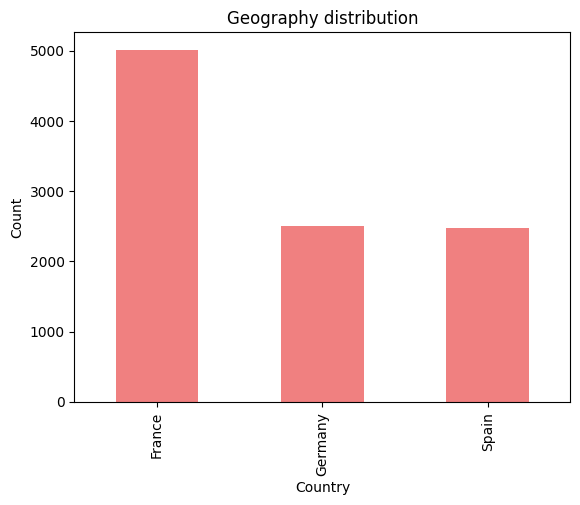

In [12]:
country_count = df['country'].value_counts()
country_count.plot(kind='bar', color = 'lightcoral')
plt.title('Geography distribution')
plt.xlabel('Country')
plt.ylabel("Count")
plt.show()

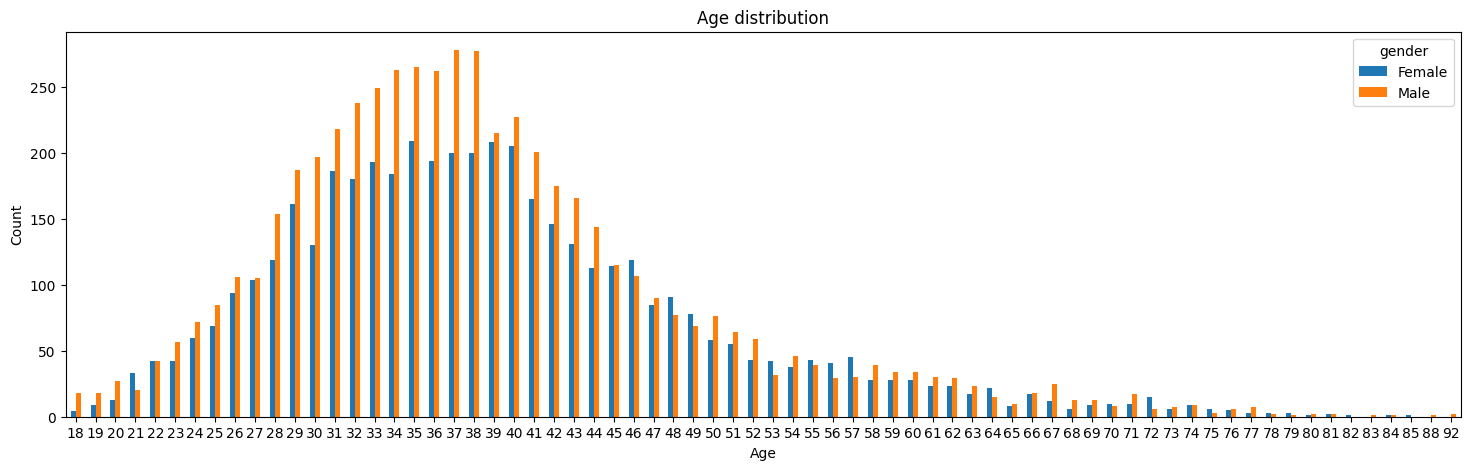

In [ ]:
age_var = df.groupby(['age','gender']).size().unstack()
age_var.plot(kind='bar', figsize = (18,5))
plt.title('Age distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [ ]:
df.sample()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
5633,15715877,821,France,Male,28,0,0.0,2,1,0,46072.52,0


In [13]:
inactive_members = df[df['active_member'] == 0]
gender_counts_inactive = inactive_members['gender'].value_counts()
gender_counts_inactive

,count
gender,
Male,2590
Female,2259


##Data Preprocessing

In [14]:
# adding the age group after 70 into 70
df['age'] = df['age'].apply(lambda x: 70 if x > 70 else x)

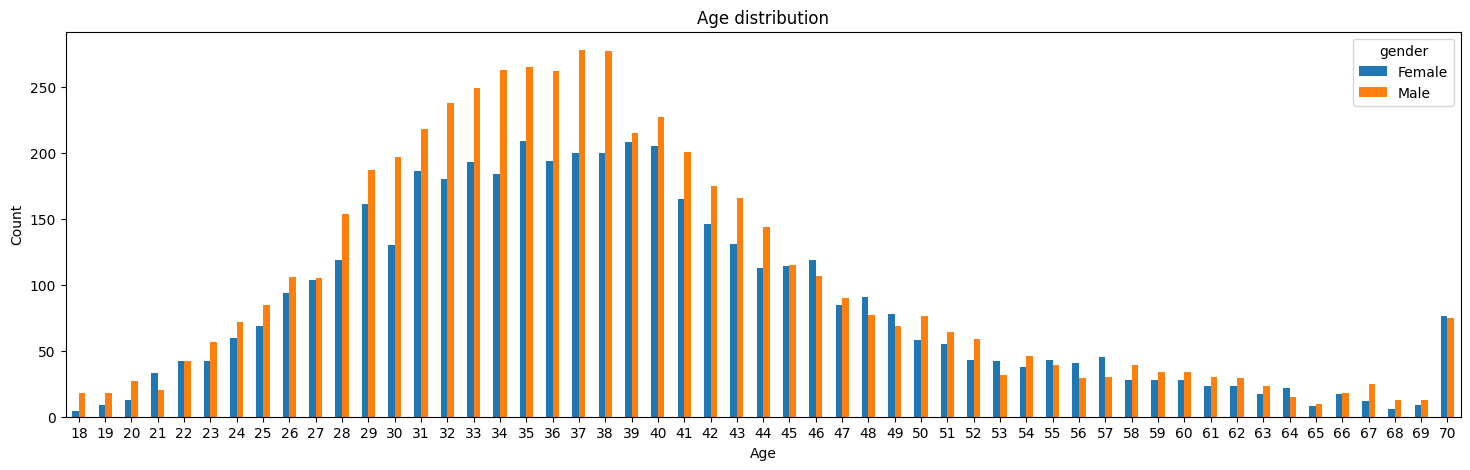

In [15]:
age_var = df.groupby(['age','gender']).size().unstack()
age_var.plot(kind='bar', figsize = (18,5))
plt.title('Age distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

## Exploratory Data Analysis using python profiling



In [ ]:
# Using Pandas Profiling latest package ydata-profiling for EDA
!pip install ydata-profiling

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.3/399.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.7/679.7 kB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 3.0 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.2
    Uninstalling scipy-1.16.2:
      Successfully uninstalled scipy-1.16.2


In [ ]:
from ydata_profiling import ProfileReport
profile = ProfileReport(df)
profile

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def tenure_group(x):
    if isinstance(x, (pd.Series, np.ndarray)):
        # Define conditions
        conditions = [
            (x <= 3),
            (x >= 4) & (x <= 6),
            (x >= 7)
        ]
        choices = [0, 1, 2]
        # Use np.select and wrap the result back as a Series
        return pd.Series(np.select(conditions, choices), index=getattr(x, "index", None))
    else:
        # Handle single numeric value
        if x <= 3:
            return 0
        elif 4 <= x <= 6:
            return 1
        else:
            return 2

In [ ]:
# Apply the tenure_group function and assign the result back to the 'tenure' column
df['tenure'] = tenure_group(df['tenure'])

# Display the unique values in the 'tenure' column to verify the transformation
print(df['tenure'].unique())

[0 2 1]


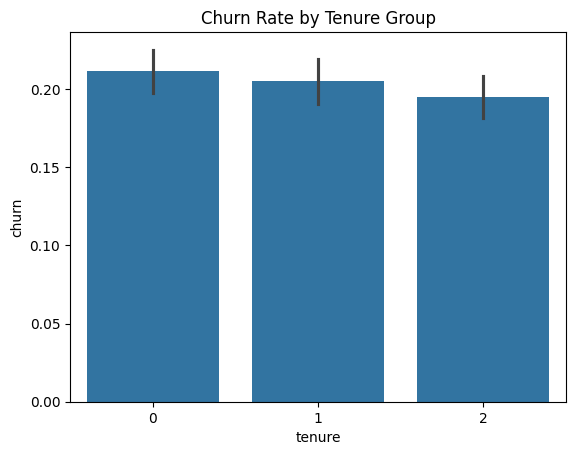

In [ ]:
# Plotting average churn rate, means for each group (0, 1, and 2), the bar shows the proportion of customers who churned.
sns.barplot(x='tenure', y='churn', data=df)
plt.title('Churn Rate by Tenure Group')
plt.show()

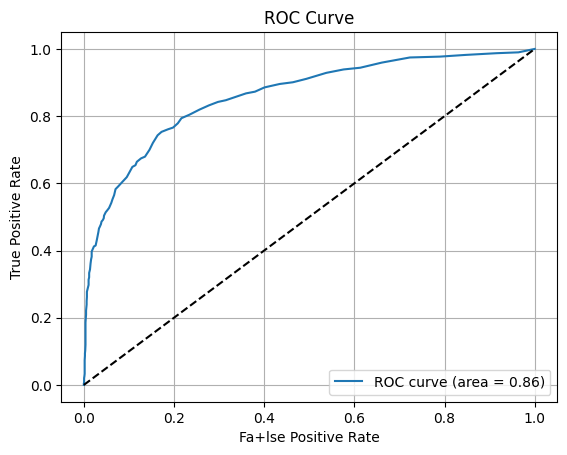

ROC-AUC Score: 0.8600


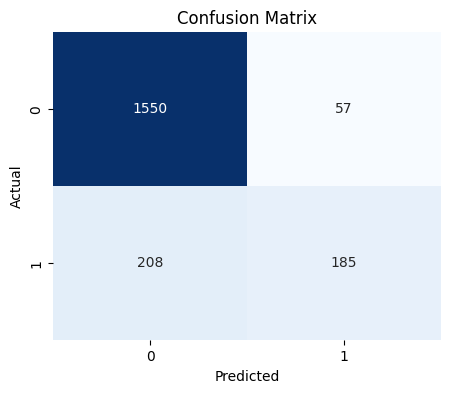

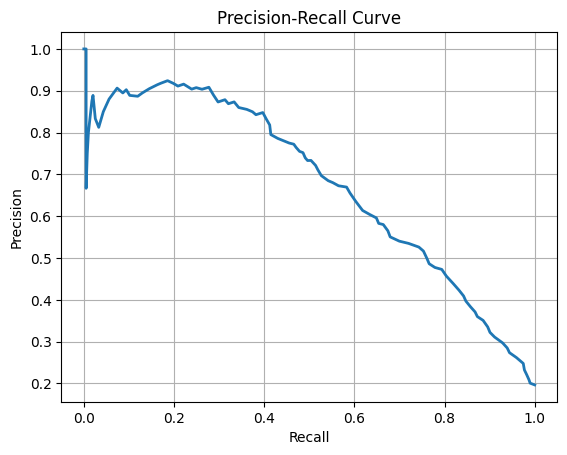

# Working on imbalance data
as in the recall value shows 0.46 means minority class showing only 46% accuracy and the precision value 0.76 means 76% of the majority class is correct.

**Task:**
Update the `ColumnTransformer` to only apply `OneHotEncoder` to 'country' and 'gender' and `StandardScaler` to the numerical columns (excluding the original 'tenure' as it's already transformed), split the preprocessed data into training and testing sets, apply SMOTENC to the training data, train the models using the preprocessed and resampled training data and evaluate their performance.

## Redefine preprocessor
Define the categorical and numerical columns and create the ColumnTransformer to only apply `OneHotEncoder` to 'country' and 'gender' and `StandardScaler` to the numerical columns (excluding the original 'tenure' as it's already transformed).




In [ ]:
X = df.drop(['churn'], axis=1)
y = df['churn']

In [ ]:
cat = ['country', 'gender']
num = [col for col in X.columns if col not in cat and col != 'tenure']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat),
        ('num', StandardScaler(), num)
    ],
    remainder='passthrough'
)

## Train-test split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Apply smote

**Reasoning**:
Apply SMOTENC to the training data to handle the class imbalance.



In [ ]:
cat = ['country', 'gender']
for col in cat:
    X_train[col] = LabelEncoder().fit_transform(X_train[col])
    X_test[col] = LabelEncoder().fit_transform(X_test[col])

cat_indices = [X_train.columns.get_loc(col) for col in cat]

smote_nc = SMOTENC(categorical_features=cat_indices, random_state=42)
X_resampled_smote, y_resampled_smote = smote_nc.fit_resample(X_train, y_train)

## Train and evaluate models

Subtask:
Train the models using the preprocessed and resampled training data and evaluate their performance.


**Reasoning**:
Iterate through the models, create a pipeline with the preprocessor and the current model, fit the pipeline on the resampled training data, predict on the test data, and print the classification report and ROC-AUC score.



In [ ]:
models = {
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier()
}

In [ ]:
for name, model in models.items():
    print(f"Training and evaluating {name}...")
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    pipe.fit(X_resampled_smote, y_resampled_smote)
    y_pred = pipe.predict(X_test)

    print(f"\nClassification Report for {name}:\n", classification_report(y_test, y_pred))

    if hasattr(model, "predict_proba"):
        y_pred_prob = pipe.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_prob)
        print(f"ROC-AUC Score for {name}: {roc_auc:.4f}")
    else:
        print(f"ROC-AUC score not available for {name}")
    print("-" * 50)

Training and evaluating KNN...

Classification Report for KNN:
               precision    recall  f1-score   support

           0       0.91      0.80      0.85      1607
           1       0.46      0.69      0.55       393

    accuracy                           0.78      2000
   macro avg       0.69      0.75      0.70      2000
weighted avg       0.83      0.78      0.79      2000

ROC-AUC Score for KNN: 0.8045
--------------------------------------------------
Training and evaluating SVM...

Classification Report for SVM:
               precision    recall  f1-score   support

           0       0.92      0.84      0.88      1607
           1       0.51      0.70      0.59       393

    accuracy                           0.81      2000
   macro avg       0.72      0.77      0.74      2000
weighted avg       0.84      0.81      0.82      2000

ROC-AUC score not available for SVM
--------------------------------------------------
Training and evaluating Decision Tree...

Classifi

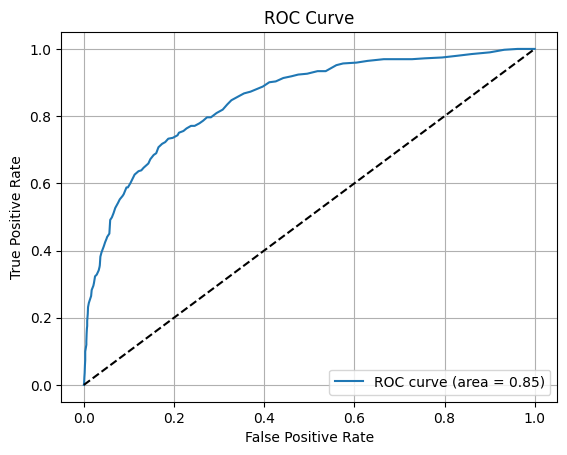

ROC-AUC Score: 0.8500


In [ ]:
# ROC curve
y_pred_prob = pipe.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_prob):.4f}")

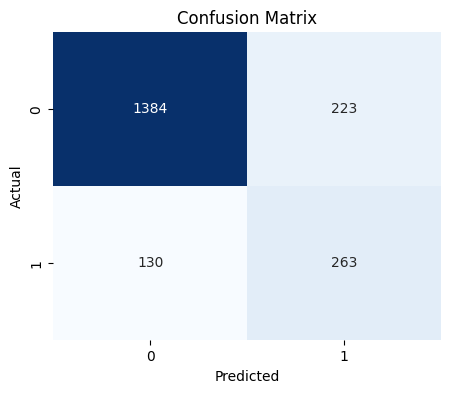

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

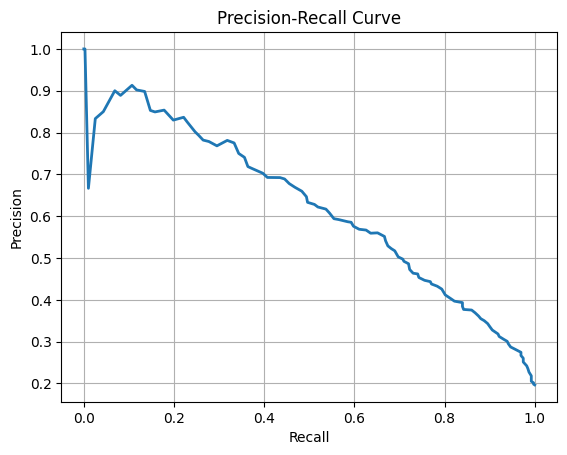

In [ ]:
# Precision Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
plt.plot(recall, precision, linewidth = 2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

## Summary

### Data Analysis Key Findings

*   The 'tenure' column was successfully transformed into groups.
*   The `ColumnTransformer` was updated to apply `OneHotEncoder` to 'country' and 'gender' and `StandardScaler` to the numerical columns (excluding the transformed 'tenure').
*   The preprocessed data was split into training and testing sets with a test size of 0.2.
*   SMOTENC was successfully applied to the training data to address class imbalance, after encoding the categorical features using `LabelEncoder`.
*   Multiple classification models (KNN, SVM, Decision Tree, Logistic Regression, Random Forest) were trained using the preprocessed and resampled training data.
*   Classification reports were generated for all models on the test set, providing precision, recall, f1-score, and support.
*   ROC-AUC scores were calculated and reported for KNN, Decision Tree, Logistic Regression, and Random Forest, indicating their ability to distinguish between classes.

### Insights or Next Steps

*   Analyze the classification reports and ROC-AUC scores to compare model performance and select the best-performing model for the task.
*   Consider hyperparameter tuning for the selected model(s) to potentially further improve performance.


#Deployment

In [ ]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 107.0 MB/s eta 0:00:00


In [ ]:
import streamlit as st


In [ ]:
# deployment using streamlit, xgboost lgana h, job apply, project update on github